# Ensemble Learning and Random Forests

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingRegressor, StackingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [2]:
X, y = make_moons(n_samples= 500, noise= 0.3, random_state= 42)
X_train ,X_test, y_train, y_test = train_test_split(X, y, random_state= 42) 

## Hard Voting Classifier

In [3]:
voting_clf = VotingClassifier([
    ('logistic', LogisticRegression(random_state= 42)),
    ('svc', SVC(random_state= 42)),
    ('rnd_forest', RandomForestClassifier(random_state= 42))
])

In [4]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('rnd_forest',
                              RandomForestClassifier(random_state=42))])

In [5]:
for name, clf in voting_clf.named_estimators_.items():
    print(f'{name} = {clf.score(X_test, y_test)}')

logistic = 0.864
svc = 0.896
rnd_forest = 0.896


In [6]:
voting_clf.score(X_test, y_test)

0.912

In [7]:
voting_clf.predict(X_test[[0]])

array([1])

In [8]:
[clf.predict(X_test[[0]]) for clf in voting_clf.estimators_]

[array([1]), array([0]), array([1])]

## Soft Voting Classifier

In [9]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True

In [10]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42)),
                             ('rnd_forest',
                              RandomForestClassifier(random_state=42))],
                 voting='soft')

In [11]:
voting_clf.score(X_test, y_test)

0.92

In [12]:
voting_clf.predict_proba(X_test[[0]])

array([[0.51627522, 0.48372478]])

In [13]:
[clf.predict_proba(X_test[[0]]) for clf in voting_clf.estimators_]

[array([[0.49899618, 0.50100382]]),
 array([[0.56982947, 0.43017053]]),
 array([[0.48, 0.52]])]

## Bagging (bootstrap aggregating) and Pasting
Set `bootstrap= False` for pasting.

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators= 500 ,max_samples= 100, random_state= 42, n_jobs= -1)

In [15]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [16]:
bag_clf.score(X_test, y_test)

0.904

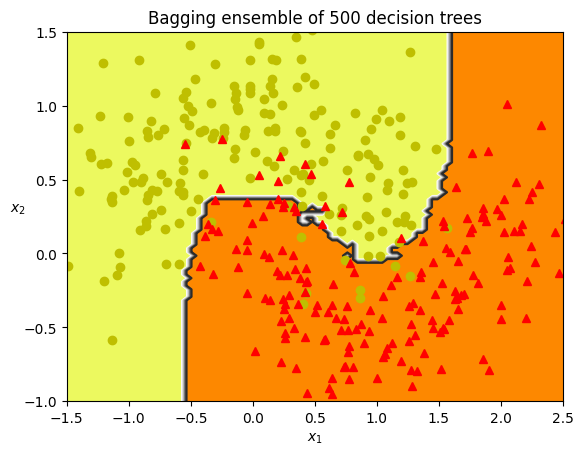

In [17]:
axes: list[float] = [-1.5, 2.5, -1, 1.5]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100), np.linspace(axes[2], axes[3], 100))
X_new: np.ndarray = np.c_[x1.ravel(), x2.ravel()]
y_pred: np.ndarray = bag_clf.predict(X_new).reshape(x1.shape)
plt.contourf(x1, x2, y_pred, cmap= 'Wistia')
plt.contour(x1, x2, y_pred, cmap= 'Greys')

plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 'yo')
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 'r^')

plt.axis(axes)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$', rotation= 0)
plt.title('Bagging ensemble of 500 decision trees')
plt.show()

### Out-of-Bag Evaluation

In [18]:
oob_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators= 500, oob_score= True, random_state= 42, n_jobs= -1)

In [19]:
oob_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True, random_state=42)

In [20]:
oob_clf.oob_score_

0.896

In [21]:
oob_clf.score(X_test, y_test)

0.92

In [22]:
oob_clf.oob_decision_function_[:5]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## Random Forests

In [23]:
rnd_forest_clf = RandomForestClassifier(
    n_estimators= 500, 
    max_leaf_nodes= 16, 
    n_jobs= -1, 
    random_state= 42
)

In [24]:
rnd_forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [25]:
rnd_forest_clf.score(X_test, y_test)

0.912

Same model as above Random Forest, using bagging.

In [26]:
bag_dt = BaggingClassifier(
    estimator= DecisionTreeClassifier(max_features= 'sqrt', max_leaf_nodes= 16),
    n_estimators= 500,
    n_jobs= -1, 
    random_state= 42
)

In [27]:
bag_dt.fit(X_train, y_train)
bag_dt.score(X_test, y_test)

0.912

### Extra-Trees

In [28]:
extra_trees_clf = ExtraTreesClassifier(n_estimators= 500, max_leaf_nodes= 16, random_state= 42)
extra_trees_clf.fit(X_train, y_train)
extra_trees_clf.score(X_test, y_test)

0.912

In [29]:
cross_val_score(rnd_forest_clf, X_test, y_test, n_jobs= -1).mean()

0.8880000000000001

In [30]:
cross_val_score(extra_trees_clf, X_test, y_test, n_jobs= -1).mean()

0.8800000000000001

### Feature Importance

In [31]:
iris: pd.DataFrame = load_iris(as_frame= True)
X_iris = iris.data
y_iris = iris.target

In [32]:
rnd_clf = RandomForestClassifier(random_state= 42)
rnd_clf.fit(X_iris, y_iris)

RandomForestClassifier(random_state=42)

In [33]:
for name, importance in zip(rnd_clf.feature_names_in_, rnd_clf.feature_importances_):
    print(f'{name} = {importance:.2%}')

sepal length (cm) = 10.61%
sepal width (cm) = 2.17%
petal length (cm) = 43.61%
petal width (cm) = 43.61%


## AdaBoost

In [34]:
ada_boost = AdaBoostClassifier(
  # estimator= DecisionTreeClassifier(max_depth= 1),   # default
    n_estimators= 30,
    learning_rate= 0.5,
    random_state= 42
)

In [35]:
ada_boost.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.5, n_estimators=30, random_state=42)

In [36]:
ada_boost.score(X_test, y_test)

0.904

## Gradient Boosting (Gradient Boosted Regression Trees) 

In [37]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

In [38]:
tree_reg1 = DecisionTreeRegressor(max_depth= 2, random_state= 42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [39]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth= 2, random_state= 42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [40]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth= 2, random_state= 42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [41]:
X_new = np.array([[-0.4], [0], [0.5]])

In [42]:
sum(reg.predict(X_new) for reg in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

In [43]:
gbrt = GradientBoostingRegressor(
    max_depth= 2, 
    n_estimators= 3,
    learning_rate= 1,
    random_state= 42
)

In [44]:
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3,
                          random_state=42)

In [45]:
gbrt.predict(X_new)

array([0.49484029, 0.04021166, 0.75026781])

In [46]:
gbrt = GradientBoostingRegressor(
    max_depth= 2, 
    learning_rate= 0.05,
    n_estimators= 500,
    n_iter_no_change= 10,
    random_state= 42
)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [47]:
gbrt.n_estimators_

92

It early stopped because continously 10 estimators doesn't improve the model.

## Stacking (Stacked Generalization)

In [50]:
stacking_clf = StackingClassifier(
    estimators= [
        ('logistic', LogisticRegression(random_state= 42)),
        ('rnd_forest', RandomForestClassifier(random_state= 42)),
        ('svc', SVC(probability= True, random_state= 42))
    ], 
    final_estimator= RandomForestClassifier(random_state= 12345),   # blender
    cv= 5
)

In [51]:
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('logistic',
                                LogisticRegression(random_state=42)),
                               ('rnd_forest',
                                RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=12345))

In [57]:
stacking_clf.score(X_test, y_test)

0.92